# <center> <img src="figs/LogoUFSCar.jpg" alt="Logo UFScar" width="110" align="left"/>  <br/> <center>Universidade Federal de São Carlos (UFSCar)<br/><font size="4"> Departamento de Computação, campus Sorocaba</center></font>
</p>

<font size="4"><center><b>Disciplina: Aprendizado de Máquina</b></center></font>
  
<font size="3"><center>Prof. Dr. Tiago A. Almeida</center></font>

## <center>Projeto Final</center>

**Aluno**: Vitor Silveira

**RA**: 802318


---
### Análise exploratória

Nesta seção, deve ser feita a leitura da base de dados e todas as análises necessárias para interpretar e analisar os dados, tais como:
* Significado de cada atributo
* Medidas descritivas
* Gráficos

### Importando algumas bibliotecas

In [2]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

### Criando um arquivo que contém todos os dados concatenados

In [ ]:
diretorio = 'data/raw_data' # diretório contendo os dados brutos

arquivos_csv = [arquivo for arquivo in os.listdir(diretorio) if arquivo.startswith('new') and arquivo.endswith('.csv')]

dados_concatenados = pd.DataFrame()

for arquivo in arquivos_csv:
   print(arquivo)
   caminho_arquivo = os.path.join(diretorio, arquivo)
   dados = pd.read_csv(caminho_arquivo)
   dados_concatenados = pd.concat([dados_concatenados, dados], ignore_index=True)

dados_concatenados.to_csv(f'data/pre_processed_data/all_news.csv', index=False)

### Fazendo a leitura dos arquivos

In [3]:
train_csv = pd.read_csv("data/raw_data/train.csv")                    # É o Y (com os labels)

test_csv = pd.read_csv("data/raw_data/test.csv")                      # Teste

sample_sub = pd.read_csv("data/raw_data/sample_submission.csv")       # Submissão

alldata = dados_concatenados

### Aqui vamos avaliar como está a distribuição das classes dos dados:
Apesar de quase metade das notícias não estarem tabuladas, resolvi remove-las pois ainda assim temos muitos dados. Sem contar os NaNs, vemos que há uma distribuição razoável de notícias falsas e verdadeiras. 

label
0.0    684397
1.0    356340
Name: count, dtype: int64
NaN count: 907147


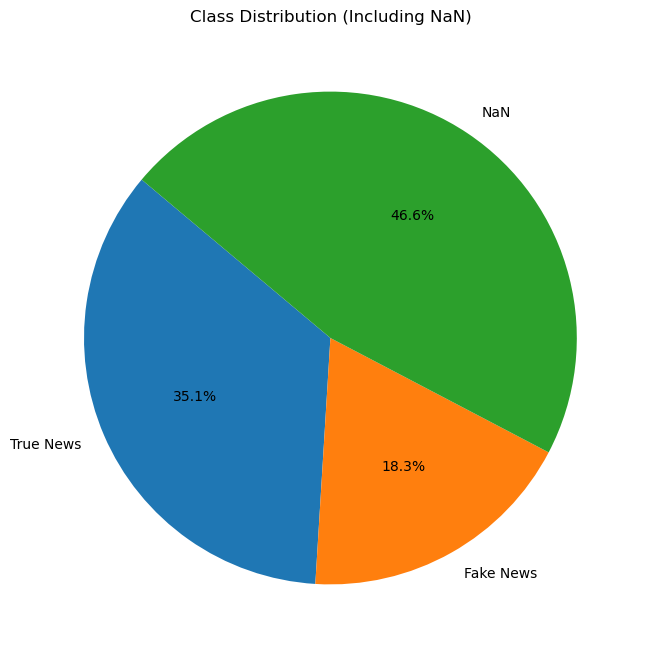

In [6]:
class_column_name = 'label'

# Count class values
class_counts = train_csv[class_column_name].value_counts()

# Count NaN values
nan_count = train_csv[class_column_name].isna().sum()

# Print class counts and NaN count
print(class_counts)
print(f"NaN count: {nan_count}")

# Map class labels
class_labels = {0: 'True News', 1: 'Fake News', float('nan'): 'NaN'}
class_counts.index = class_counts.index.map(class_labels)

# Add NaN count to the class counts
class_counts['NaN'] = nan_count

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution (Including NaN)')
plt.show()

In [ ]:
test = test_csv.merge(alldata, on = "id")
test

In [ ]:
joinned_train = train_csv.merge(alldata, on = "id")
joinned_train

In [ ]:
joinned_train.dropna(inplace = True)

---
### Pré-processamento

Nesta seção, as funções da etapa de pré-processamento dos dados devem ser implementadas e aplicadas (se necessário).

Vamos dropar as colunas id e data, já que elas não trazem muita informação sobre o conteúdo da notícia. Fazendo isso, deixamos o dataset um pouco mais leve também. Após fazer isso, vamos concatenar o título com o conteúdo, criando uma nova coluna chamada "title_content". Com isso feito, vamos dropar as colunas "content" e "title".

In [ ]:
joinned_train.drop(columns = [ "id", "date" ], inplace = True)
test.drop(columns = [ "id", "date" ], inplace = True)

In [ ]:
joinned_train["title_content"] = joinned_train["title"] + " " + joinned_train["content"]
test["title_content"] = test["title"] + " " + test["content"]

joinned_train.drop(columns = [ "title", "content" ], inplace = True)
test.drop(columns = [ "title", "content" ], inplace = True)

### Fazendo o pré-processamento do texto:
Etapas:
 - Remover stopwords;
 - Remover pontuação;
 - Deixar o texto todo em minúsculo. 

In [10]:
import nltk
from nltk.corpus import stopwords
import string

nltk.download('stopwords')

rm_punctuation = string.punctuation

stopw = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopw])

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', rm_punctuation))

def to_lowercase(text):
    return text.lower()

def preprocess_text(text):
    if pd.isnull(text):
        return ""

    text = remove_punctuation(text)

    text = remove_stopwords(text)

    text = to_lowercase(text)

    return text

[nltk_data] Downloading package stopwords to /home/vitor/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
joinned_train["title_content"] = joinned_train["title_content"].apply(lambda text: preprocess_text(text))
test["title_content"] = test["title_content"].apply(lambda text: preprocess_text(text))

---
### Experimento

Nesta seção, o experimento deve ser conduzido, utilizando os protocolos experimentais padrões e testando diferentes modelos.

Começaremos o experimento extraindo as features do dataset de treinamento (joinned_train). Para isso, vamos separar as colunas "title_content" e "label" em X e y_train

In [ ]:
X = joinned_train["title_content"].astype(str)
y_train = joinned_train["label"]
X_test = test["title_content"].apply(lambda x: np.str_(x))

Aqui, vamos de fato fazer a extração de features:
Utilizaremos a técnica TF-IDF (Term Frequency-Inverse Document Frequency) para vetorizar o texto. Estou usando o parâmetro max_features = 8000 para balancear o desempenho computacional.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer(max_features = 8000)
x_train = vectorization.fit_transform(X)
X_test_vec = vectorization.transform(X_test)

Agora vamos treinar os modelos. O modelo escolhido na submissão final foi o XGBoost, pois ele obteve um public_score melhor do que a Regressão linear.

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(objective='binary:logistic')
xgb.fit(x_train, y_train)
predXGB = xgb.predict_proba(X_test_vec)

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs', max_iter=1000).fit(x_train, y_train)
print("passo 1")
predRL = clf.predict_proba(X_test_vec)
print("passo 2")

Aqui, estamos criando os arquivos de submissão para o kaggle.

In [ ]:
sample_sub = pd.read_csv("data/raw_data/sample_submission.csv")   
sample_sub["label"] = predXGB[:, 1] 
sample_sub.set_index("id").to_csv("default-xgb-alldata.csv")
sample_sub["label"] = predRL[:, 1] 
sample_sub.set_index("id").to_csv("default-LR-alldata.csv")

---
### Análise dos Resultados

Nesta seção, os resultados devem ser exibidos através de tabelas e gráficos, comparados e profundamente analisados.

Vamos re-treinar os modelos usando um dataset menor e usar dois meses como teste desses modelos.

In [7]:
# vamos usar 6 meses de dados: 3/19, 5/19, 12/19, 4/20, 7/20 e 10/20
import pandas as pd
import numpy as np

sampĺe1 = pd.read_csv("data/raw_data/news_data_03_Mar_2019.csv")
sample2 = pd.read_csv("data/raw_data/news_data_05_May_2019.csv")
sample3 = pd.read_csv("data/raw_data/news_data_12_Dec_2019.csv")
sample4 = pd.read_csv("data/raw_data/news_data_16_Apr_2020.csv")
sample5 = pd.read_csv("data/raw_data/news_data_19_Jul_2020.csv")
sample6 = pd.read_csv("data/raw_data/news_data_22_Oct_2020.csv")
test1 = pd.read_csv("data/raw_data/news_data_02_Feb_2019.csv")
test2 = pd.read_csv("data/raw_data/news_data_20_Aug_2020.csv")
train_csv = pd.read_csv("data/raw_data/train.csv")

test = pd.concat([test1, test2])
test = test.merge(train_csv, on = "id")
test.dropna(inplace = True)

joinned_train = pd.concat([sampĺe1, sample2, sample3, sample4, sample5, sample6])
joinned_train = joinned_train.merge(train_csv, on = "id")
joinned_train.dropna(inplace = True)

In [8]:
joinned_train["title_content"] = joinned_train["title"] + " " + joinned_train["content"]
joinned_train.drop(columns = [ "id", "date", "title", "content" ], inplace = True)

In [9]:
test["title_content"] = test["title"] + " " + test["content"]
test.drop(columns = [ "id", "date", "title", "content" ], inplace = True)

In [11]:
joinned_train["title_content"] = joinned_train["title_content"].apply(lambda text: preprocess_text(text))
test["title_content"] = test["title_content"].apply(lambda text: preprocess_text(text))

In [12]:
X = joinned_train["title_content"].astype(str)
y_train = joinned_train["label"]
y_test = test["label"]
X_test = test["title_content"].apply(lambda x: np.str_(x))

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer(max_features = 8000)
x_train = vectorization.fit_transform(X)
X_test_vec = vectorization.transform(X_test)

In [14]:
from xgboost import XGBClassifier

xgb = XGBClassifier(objective='binary:logistic')
xgb.fit(x_train, y_train)
predXGB = xgb.predict_proba(X_test_vec)

In [15]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs', max_iter=1000).fit(x_train, y_train)
print("passo 1")
predRL = clf.predict_proba(X_test_vec)
print("passo 2")

passo 1
passo 2


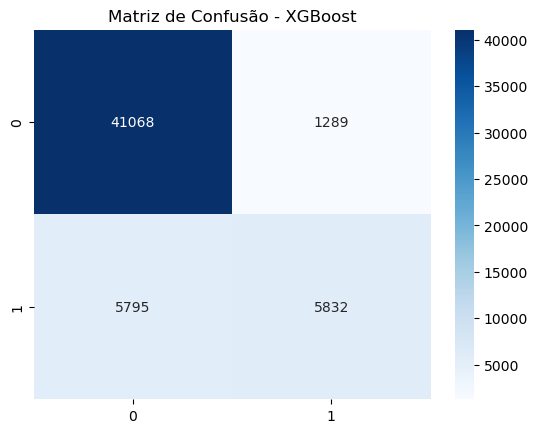

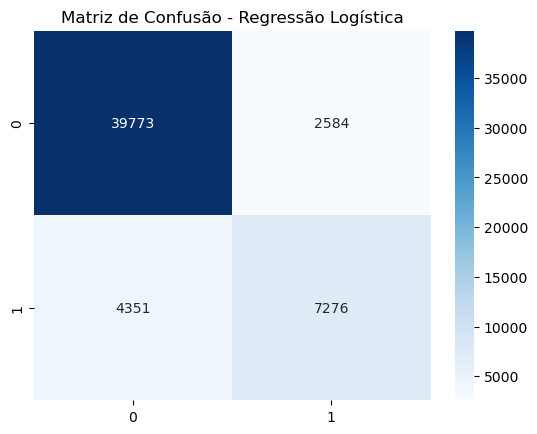

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de Confusão para XGBoost
cm_xgb = confusion_matrix(y_test, predXGB.argmax(axis=1))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title("Matriz de Confusão - XGBoost")
plt.show()

# Matriz de Confusão para Regressão Logística
cm_lr = confusion_matrix(y_test, predRL.argmax(axis=1))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title("Matriz de Confusão - Regressão Logística")
plt.show()

Analisando essas matrizes de confusão, vemos que ambos modelos estão especialmente classificando corretamente as notícias verdadeiras e que estão classificando mais notícias falsas como verdadeiras do que verdadeiras como falsas.

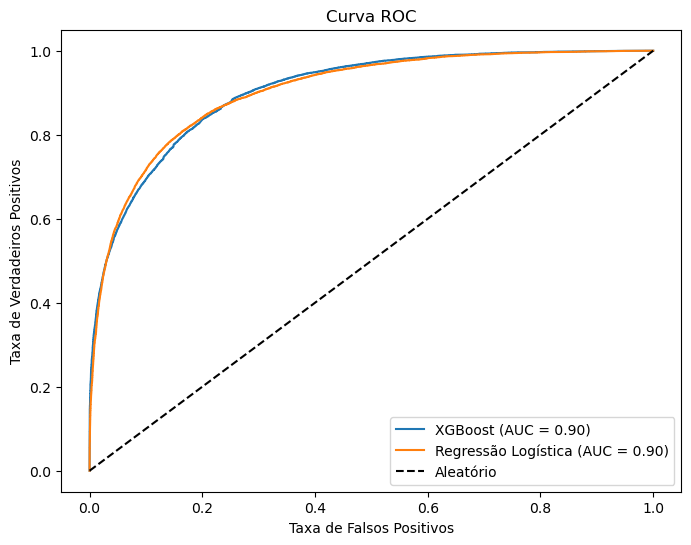

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score

# Curva ROC para XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, predXGB[:, 1])
auc_xgb = roc_auc_score(y_test, predXGB[:, 1])

# Curva ROC para Regressão Logística
fpr_lr, tpr_lr, _ = roc_curve(y_test, predRL[:, 1])
auc_lr = roc_auc_score(y_test, predRL[:, 1])

# Plotar as Curvas ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Regressão Logística (AUC = {auc_lr:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

Analisando as curvas, vemos que o modelo possui um bom poder discriminativo, indicando AUCs de 0.9. 

In [20]:
from sklearn.metrics import classification_report

# Relatório de Classificação para XGBoost
report_xgb = classification_report(y_test, xgb.predict(X_test_vec))
print("Relatório de Classificação - XGBoost:")
print(report_xgb)

# Relatório de Classificação para Regressão Logística
report_lr = classification_report(y_test, clf.predict(X_test_vec))
print("Relatório de Classificação - Regressão Logística:")
print(report_lr)

Relatório de Classificação - XGBoost:
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92     42357
         1.0       0.82      0.50      0.62     11627

    accuracy                           0.87     53984
   macro avg       0.85      0.74      0.77     53984
weighted avg       0.86      0.87      0.86     53984

Relatório de Classificação - Regressão Logística:
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92     42357
         1.0       0.74      0.63      0.68     11627

    accuracy                           0.87     53984
   macro avg       0.82      0.78      0.80     53984
weighted avg       0.87      0.87      0.87     53984



### XGBoost:

Para a classe 0.0, a precisão é alta (0.88), o que indica que a maioria das instâncias classificadas como 0.0 pelo modelo são realmente 0.0. Para a classe 1.0, a precisão é mais baixa (0.82), sugerindo que há algum nível de falsos positivos. Assim como vimos na matriz de confusão.

A revocação para a classe 0.0 é alta (0.97), indicando que o modelo é eficaz em identificar a maioria das instâncias verdadeiramente positivas. No entanto, para a classe 1.0, a revocação é mais baixa (0.50), o que significa que o modelo está perdendo algumas instâncias positivas. Isso também foi visto na matriz de confusão. 

### Regressão Logística

A precisão para ambas as classes é razoavelmente boa, sendo mais alta para a classe 0.0 (0.90) e um pouco mais baixa para a classe 1.0 (0.74).

A revocação para a classe 0.0 é alta (0.94), indicando que o modelo é eficaz em identificar a maioria das instâncias verdadeiramente positivas. Para a classe 1.0, a revocação é mais baixa (0.63), indicando que o modelo está perdendo algumas instâncias positivas.

### Comparação Geral

Ambos os modelos têm uma acurácia geral (accuracy) de aproximadamente 0.87, indicando a proporção de instâncias corretamente classificadas.



O modelo XGBoost parece ter uma melhor revocação para a classe 1.0, enquanto a Regressão Logística tem uma precisão ligeiramente melhor para ambas as classes.

No public_score, quem levou a melhor foi o XGBoost. Treinando com todos os dados, ele alcançou 0.77812, enquanto a Regrassão Logística ficou no 0.7553